In [61]:
import pandas as pd
from data_loading import load_tracking_data
import matplotlib.pyplot as plt
import os
import seaborn as sns

import numpy as np
from scipy import spatial

# Explore defensive data

Most of our analysis has been focused on the offensive side of the ball, so we now turn to defense:

In [62]:
# load tracking data for all weeks
root_dir = os.getcwd()
tracking_fname_list = [os.path.join(root_dir,  f"data/tracking_week_{i}.csv") for i in range(1,10)]
df_tracking = pd.concat(
        [load_tracking_data(tracking_fname) for tracking_fname in tracking_fname_list]
    )
df_players = pd.read_csv(os.path.join(root_dir,'data/players.csv'))

Get relevant columns, truncate tracking:

In [63]:
cols_standard = [x for x in df_tracking if '_standard' in x]
cols_track = ['gameId','playId','nflId','frameId','club','a','s','dis'] + cols_standard
track_trunc = df_tracking[cols_track]

In [64]:
del(df_tracking)

Import play data, merge tracking onto play-level data:

In [65]:
df_plays = pd.read_csv(os.path.join(root_dir,'data/plays.csv'))
play_trunc = df_plays[['gameId','playId','defensiveTeam']]
pt_df = play_trunc.merge(track_trunc,how='left',left_on=['gameId','playId','defensiveTeam'],
                 right_on=['gameId','playId','club'])

# na's dropped to lose players w/o tracking info
def_df = pt_df.dropna().copy()
def_df.head(3)

,gameId,playId,defensiveTeam,nflId,frameId,club,a,s,dis,o_standard,dir_standard,x_standard,y_standard
0,2022102302,2655,ATL,46091.0,1.0,ATL,0.23,0.39,0.04,245.70,43.62,36.76,25.32
1,2022102302,2655,ATL,46091.0,2.0,ATL,0.64,0.49,0.05,249.66,23.66,36.78,25.37
2,2022102302,2655,ATL,46091.0,3.0,ATL,0.87,0.58,0.06,256.06,11.90,36.79,25.43


Aggregate pairwise dist, excluding defenive linemen:

In [66]:
# get position here for calcs
def_temp = def_df.merge(df_players[['nflId','position','weight']],how='left')

# get mean pairwise distance between each player in x, y, and overall directions, excluding DL who mess with things
pw_total =def_temp[~def_temp.position.isin(['DE','DT','NT'])].groupby(['gameId','playId']).apply(lambda x: spatial.distance.pdist(np.array(list(zip(x.x_standard, x.y_standard)))).mean()).reset_index().rename(columns={0:'mean_pairwise_dist'})
pw_x =def_temp[~def_temp.position.isin(['DE','DT','NT'])].groupby(['gameId','playId']).apply(lambda x: spatial.distance.pdist(np.array(list(zip(x.x_standard, x.x_standard)))).mean()).reset_index().rename(columns={0:'pairwise_mean_x'})
pw_y = def_temp[~def_temp.position.isin(['DE','DT','NT'])].groupby(['gameId','playId']).apply(lambda x: spatial.distance.pdist(np.array(list(zip(x.y_standard, x.y_standard)))).mean()).reset_index().rename(columns={0:'pairwise_mean_y'})
pw_total.head(2)

,gameId,playId,mean_pairwise_dist
0,2022090800,56,10.823594
1,2022090800,80,12.818117


Aggregate metrics for columns of interest at the player-play level, collapsing frames:

In [67]:
# define columns and what aggregations we want applied
agg_cols = ['a','s','dis']+cols_standard
agg_dict = {}
for col in agg_cols:
    agg_dict[col] = ['sum','mean','min','max']

# group by player-play keys and aggregate
def_grp = def_df.groupby(['gameId','playId','nflId']).agg(agg_dict)
def_grp.columns = ['_'.join(col).rstrip('_') for col in def_grp.columns]
def_grp.reset_index(inplace=True)
def_grp.head(4)

,gameId,playId,nflId,a_sum,a_mean,a_min,a_max,s_sum,s_mean,s_min,...,dir_standard_min,dir_standard_max,x_standard_sum,x_standard_mean,x_standard_min,x_standard_max,y_standard_sum,y_standard_mean,y_standard_min,y_standard_max
0,2022090800,56,38577.0,62.77,0.435903,0.01,1.67,62.31,0.432708,0.01,...,4.95,359.11,5755.17,39.966458,38.17,40.60,3469.03,24.090486,23.173333,24.933333
1,2022090800,56,41239.0,38.31,0.266042,0.00,0.89,44.50,0.309028,0.00,...,34.85,309.30,5205.41,36.148681,35.73,37.30,3061.89,21.263125,20.863333,23.443333
2,2022090800,56,42816.0,73.21,0.508403,0.03,1.18,173.75,1.206597,0.09,...,0.42,358.86,5913.49,41.065903,38.03,42.86,5638.75,39.157986,28.823333,44.563333
3,2022090800,56,43294.0,78.67,0.546319,0.05,1.54,142.93,0.992569,0.24,...,26.54,191.17,5810.20,40.348611,38.46,41.98,1993.18,13.841528,8.763333,20.543333


Flag for dropbacks, merge in weight info:

In [68]:
def_flagged = def_grp.merge(df_plays[['gameId','playId','isDropback']],how='left',on=['gameId','playId'])
def_pos = def_flagged.merge(df_players[['nflId','position','weight']],how='left')

In [69]:
def_pos[['gameId','playId','nflId']].duplicated().sum()

0

Check defensive position counts:

In [70]:
def_pos['position'].value_counts()

CB     42135
OLB    23287
DE     22936
ILB    21862
DT     21415
FS     18192
SS     17399
NT      5681
MLB     3630
LB       305
DB       103
WR         1
Name: position, dtype: int64

Below charts similar across FS/SS; was hoping for meaningful X-positioning difference for safeties, but no such luck

<Axes: >

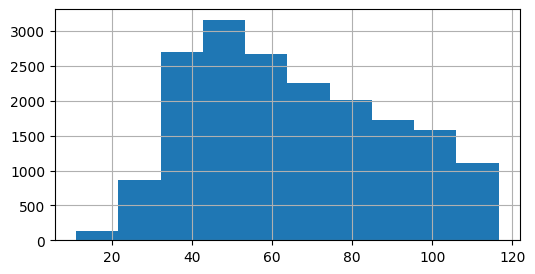

In [71]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
def_pos[def_pos['position'] == 'FS']['x_standard_min'].hist()
#def_pos[~def_pos['position'].isin(['FS','SS'])]['x_standard_min'].hist()
#def_pos[def_pos['position'] == 'SS']['x_standard_min'].hist()

# Explore Defensive Back data

DB'S (safeties/corners) and CB's (corners) explored here

In [72]:
# filter out positional groups
def_pos['is_db'] = def_pos['position'].isin(['CB','FS','SS','DB'])
def_pos['is_dl'] = def_pos['position'].isin(['DE','DT','NT'])
def_pos['is_lb'] = def_pos['position'].isin(['MLB','LB','OLB'])

See how many CB's on the field for each play:

In [73]:
def_pos.groupby(['gameId','playId'])['is_db'].sum().reset_index()['is_db'].value_counts()

5    10171
4     4059
6     1587
3      121
7      105
2       19
1       16
8        8
Name: is_db, dtype: int64

### Apply orientation adjustments

Nominally, a forward-facing CB is oriented at 270 degrees. We subtract this from players' mean orientation, and also abs. value it

In [74]:
# separate out db's, cb's
def_dbs = def_pos[def_pos['is_db']].copy()
def_cbs = def_pos[def_pos['position'] == 'CB'].copy()

# get 270-offset orientation with and without abs value applied
def_dbs['abs_orientation_offset'] = np.abs(def_dbs['o_standard_mean'].values - 270)
def_dbs['orientation_offset'] = def_dbs['o_standard_mean'].values - 270
def_cbs['abs_orientation_offset'] = np.abs(def_cbs['o_standard_mean'].values - 270)
def_cbs['orientation_offset'] = def_cbs['o_standard_mean'].values - 270

# median player orientation is roughly 270
def_dbs['o_standard_mean'].median()

263.9995

Get mean/median orientation, across all CB's/DB's present on a given play (offset by 270)

In [75]:
# mean offset
db_mean = def_dbs.groupby(['gameId','playId'])[['orientation_offset','abs_orientation_offset']].mean().reset_index().rename(columns={'abs_orientation_offset':'mean_offset_db_orientation_abs',
                                                                                                                                   'orientation_offset':'mean_offset_db_orientation'})
cb_mean = def_cbs.groupby(['gameId','playId'])[['orientation_offset','abs_orientation_offset']].mean().reset_index().rename(columns={'abs_orientation_offset':'mean_offset_cb_orientation_abs',
                                                                                                                                   'orientation_offset':'mean_offset_cb_orientation'})

# median offset
db_median = def_dbs.groupby(['gameId','playId'])[['orientation_offset','abs_orientation_offset']].median().reset_index().rename(columns={'abs_orientation_offset':'median_offset_db_orientation_abs',
                                                                                                                                   'orientation_offset':'median_offset_db_orientation'})
cb_median = def_cbs.groupby(['gameId','playId'])[['orientation_offset','abs_orientation_offset']].median().reset_index().rename(columns={'abs_orientation_offset':'mean_offset_cb_orientation_abs',
                                                                                                                                   'orientation_offset':'median_offset_cb_orientation'})

### Aggregate weight, positional info

We want to see if player weight has bearing on our model, as well as how many of each position are on the field

In [76]:
# define groups to aggregate by
pos_dict = {}
for x in ['is_db','weight','is_dl','is_lb']: pos_dict[x] = 'sum'
pos_dict['weight'] = ['min','sum']

# get total weights, count of position groups on field
df_sum_full = def_pos.groupby(['gameId','playId']).agg(pos_dict).reset_index().rename(columns={'is_db':'db_ct','is_dl':'dl_ct','weight':'weight_all'})
df_sum_full.columns = ['_'.join(col).rstrip('_') for col in df_sum_full.columns]
df_sum_full = df_sum_full.rename(columns={'dl_ct_sum':'dl_ct','is_lb_sum':'lb_ct','db_ct_sum':'db_ct'})
df_sum_full.head(2)

,gameId,playId,db_ct,weight_all_min,weight_all_sum,dl_ct,lb_ct
0,2022090800,56,5,184,2639,4,0
1,2022090800,80,5,184,2639,4,0


In [77]:
df_sum_full[['gameId','playId']].duplicated().sum()

0

Agg weight, but only for heaviest (or lightest) five players

In [78]:
wt5 = def_pos.sort_values(by=['gameId','playId','weight'],ascending=False).groupby(['gameId','playId']).head(5).groupby(['gameId','playId'])['weight'].sum().reset_index().rename(columns={'weight':'weight_top5'})
wm5 = def_pos.sort_values(by=['gameId','playId','weight']).groupby(['gameId','playId']).head(5).groupby(['gameId','playId'])['weight'].sum().reset_index().rename(columns={'weight':'weight_min5'})

Merge it all in:

In [79]:
df_further = df_sum_full.merge(wt5,how='left',on=['gameId','playId'])
df_further = df_further.merge(wm5,how='left',on=['gameId','playId'])
df_g= df_further.merge(df_plays[['gameId','playId','isDropback']],how='left',on=['gameId','playId'])
df_gb = df_g.merge(db_mean,how='left')
dfc = df_gb.merge(cb_mean,how='left')
dfc = dfc.merge(cb_median,how='left')
dfc = dfc.merge(db_median,how='left')
dfc = dfc.merge(pw_x,how='left')
dfc = dfc.merge(pw_y,how='left')
dfc = dfc.merge(pw_total,how='left')

In [80]:
dfc[['gameId','playId']].duplicated().sum()

0

In [81]:
dfc.head(2)

,gameId,playId,db_ct,weight_all_min,weight_all_sum,dl_ct,lb_ct,weight_top5,weight_min5,isDropback,mean_offset_db_orientation,mean_offset_db_orientation_abs,mean_offset_cb_orientation,mean_offset_cb_orientation_abs,median_offset_cb_orientation,median_offset_db_orientation,median_offset_db_orientation_abs,pairwise_mean_x,pairwise_mean_y,mean_pairwise_dist
0,2022090800,56,5,184,2639,4,0,1404,1005,True,-29.802389,39.849639,-33.915382,59.033507,-33.915382,-33.353681,33.353681,4.052729,13.928760,10.823594
1,2022090800,80,5,184,2639,4,0,1404,1005,True,-12.323241,27.345678,-2.082184,37.509885,-2.082184,-9.417241,35.427701,4.905973,16.454608,12.818117


In [82]:
df_games = pd.read_csv(os.path.join(root_dir,'data/games.csv'))

In [83]:
dfc = dfc.merge(df_games[['gameId','week']],how='left')

Subset to train to explore correlations:

In [84]:
df_train = dfc[dfc['week'] < 9]

# Correlation EDA

Below we show that weight, CB features are generally uncorrelated:

Text(0.5, 1.0, 'All features')

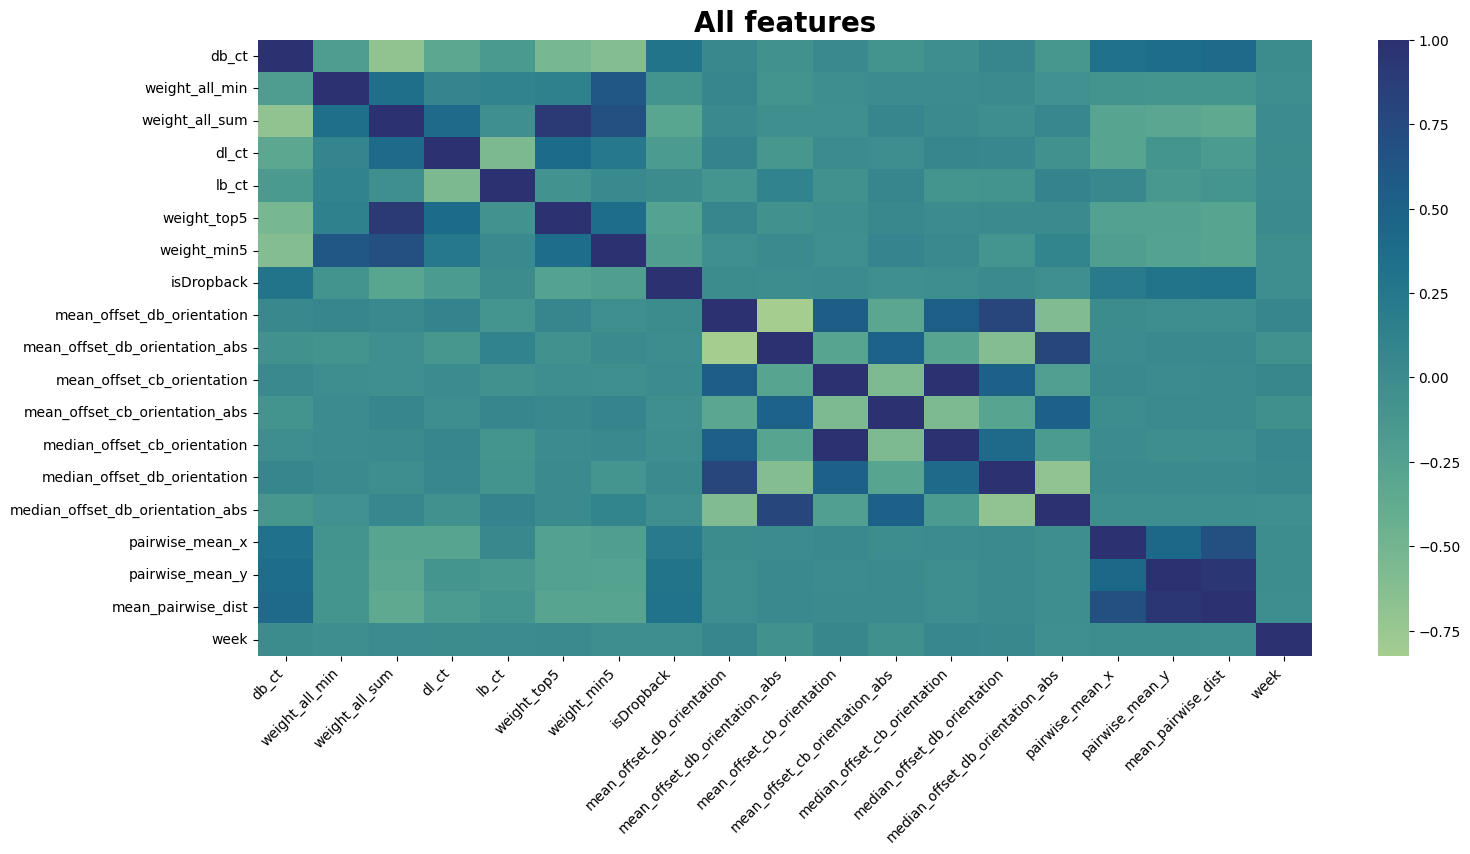

In [85]:
plt.figure(figsize=(17,8));

sns.heatmap(df_train.drop(columns=['gameId','playId'],inplace=False).corr(),cmap="crest");
plt.xticks(rotation=45,ha='right');
plt.title('All features',fontsize=20,fontweight='bold')

Subset to CB/DB cols:

Text(0.5, 1.0, 'DB Subset')

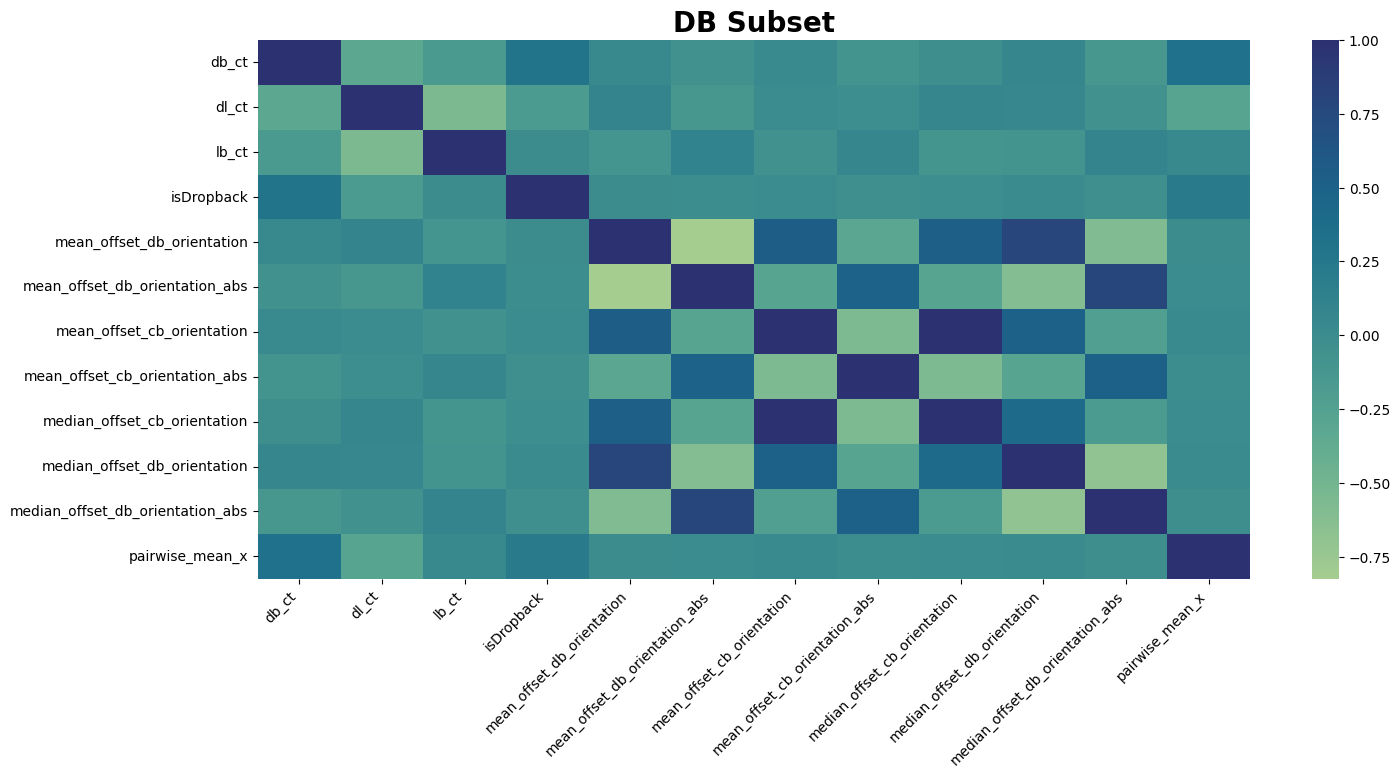

In [86]:
plt.figure(figsize=(16,7));

sns.heatmap(df_train.drop(columns=['gameId','playId','weight_all_min','weight_all_sum','weight_top5','weight_min5'],inplace=False).iloc[:,:-3].corr(),cmap="crest");
plt.xticks(rotation=45,ha='right');
plt.title('DB Subset',fontsize=20,fontweight='bold')

Get a correlation heatmap:

<Axes: title={'center': 'Correlation Heatmap of Features'}>

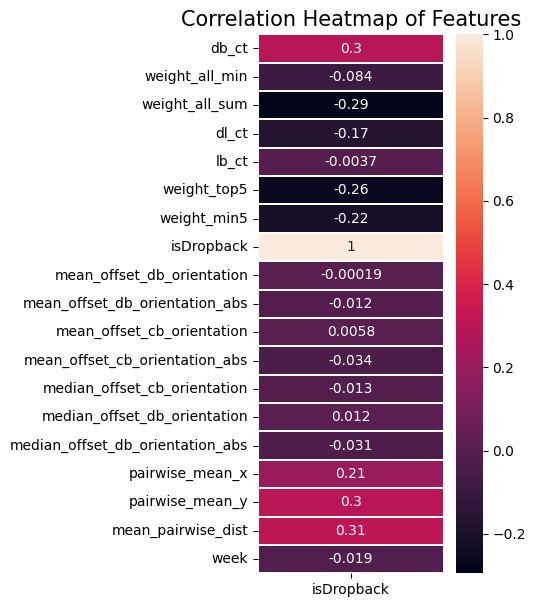

In [87]:
plt.figure(figsize=(3,7))
plt.title('Correlation Heatmap of Features', size=15)

sns.heatmap(df_train.drop(columns=['gameId','playId'],inplace=False).corr()[['isDropback']],linewidths=0.1,vmax=1.0,  linecolor='white', annot=True)

## Key Feature EDA

'Key' features are defined as ones we want to add to our model, based on importance/uniqueness

Uniqueness --> low corr. with other features, while still providing value

In [88]:
key_corr = df_train[['weight_all_sum','db_ct','dl_ct','mean_pairwise_dist','mean_offset_db_orientation_abs','isDropback']].corr()
key_corr

,weight_all_sum,db_ct,dl_ct,mean_pairwise_dist,mean_offset_db_orientation_abs,isDropback
weight_all_sum,1.000000,-0.690911,0.407209,-0.344277,-0.029523,-0.294556
db_ct,-0.690911,1.000000,-0.324313,0.409164,-0.067702,0.296905
dl_ct,0.407209,-0.324313,1.000000,-0.170761,-0.121405,-0.171098
mean_pairwise_dist,-0.344277,0.409164,-0.170761,1.000000,0.032221,0.309695
mean_offset_db_orientation_abs,-0.029523,-0.067702,-0.121405,0.032221,1.000000,-0.011925
isDropback,-0.294556,0.296905,-0.171098,0.309695,-0.011925,1.000000


Text(0.5, 1.0, 'Key defensive features')

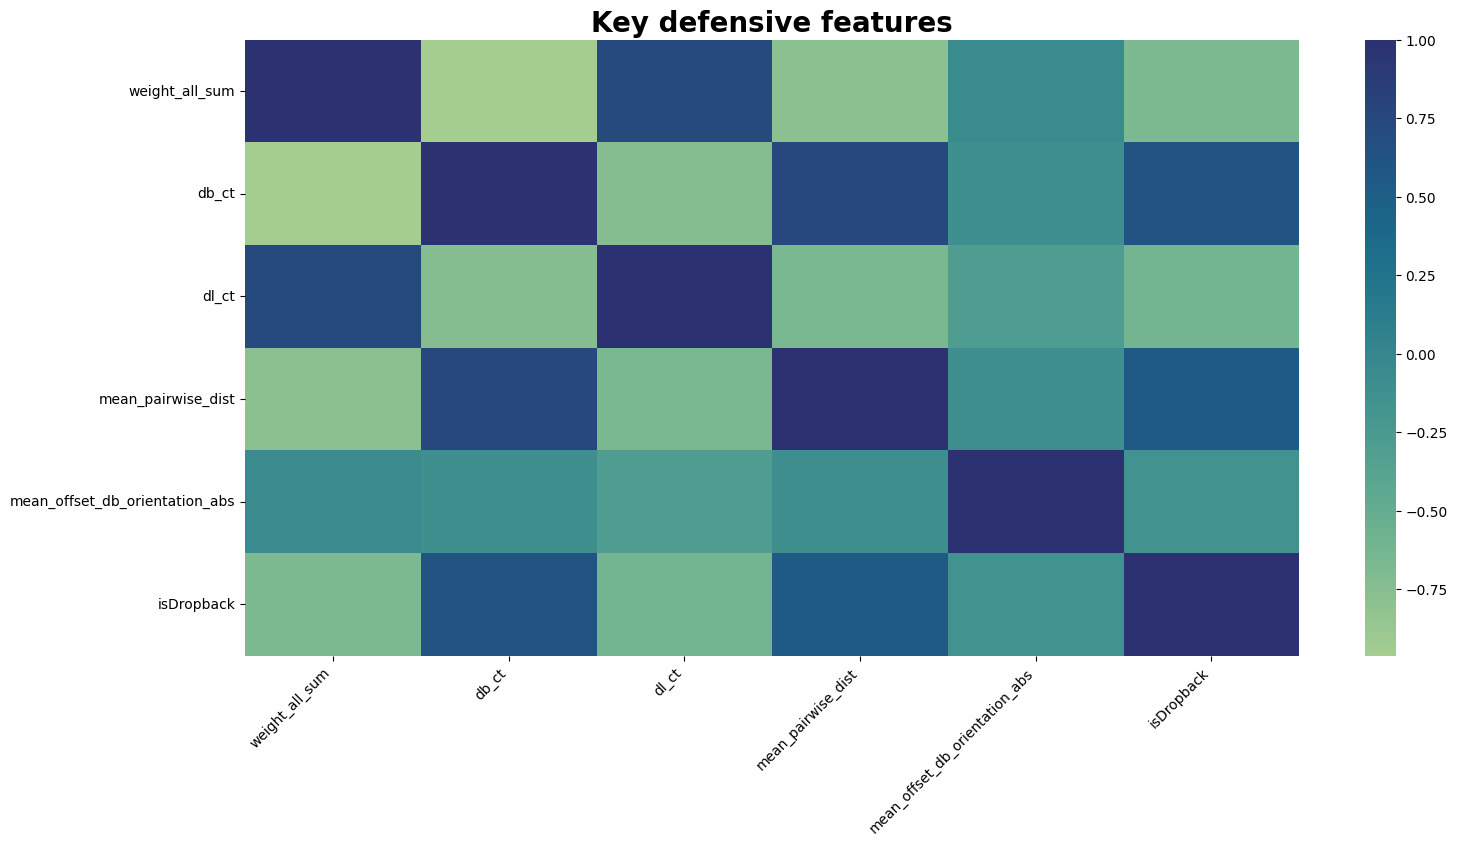

In [89]:
plt.figure(figsize=(17,8));

sns.heatmap(key_corr.corr(),cmap="crest");
plt.xticks(rotation=45,ha='right');
plt.title('Key defensive features',fontsize=20,fontweight='bold')

### Takeaways

One issue is many of these features are very highly related; db_ct was notably excluded due to a .7 corr with weight_all_sum. 

Highest remaining correlations between features is roughly .4 (in weight, # of defensive lineman, and average db orientation)



<Axes: title={'center': 'Correlation Heatmap of Features'}>

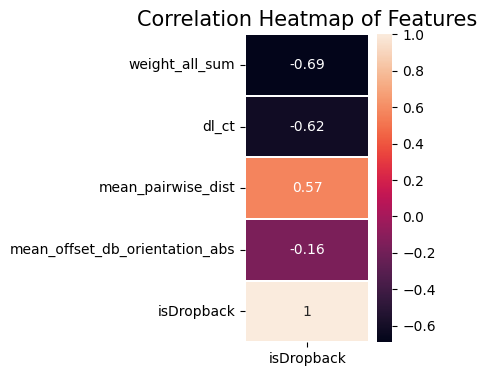

In [90]:
plt.figure(figsize=(2,4))
plt.title('Correlation Heatmap of Features', size=15)

sns.heatmap(key_corr.drop(columns=['db_ct']).corr()[['isDropback']],linewidths=0.1,vmax=1.0,  linecolor='white', annot=True)

Note also how our only NA features are CB-related, yet DB's are fine—lack of cb's may be an issue on some plays.

Ergo, we go with DB offset, even though it's slightly worse than CB offset

In [91]:
df_train.isna().sum()

gameId                                 0
playId                                 0
db_ct                                  0
weight_all_min                         0
weight_all_sum                         0
dl_ct                                  0
lb_ct                                  0
weight_top5                            0
weight_min5                            0
isDropback                             0
mean_offset_db_orientation             0
mean_offset_db_orientation_abs         0
mean_offset_cb_orientation            41
mean_offset_cb_orientation_abs        41
median_offset_cb_orientation        8982
median_offset_db_orientation           0
median_offset_db_orientation_abs       0
pairwise_mean_x                        0
pairwise_mean_y                        0
mean_pairwise_dist                     0
week                                   0
dtype: int64

In [92]:
df_train[['gameId','playId']].duplicated().sum()

0

### Write out files

We write out a separate file for train and test data:

In [93]:
df_test = dfc[dfc['week'] == 9][['gameId','playId','weight_all_sum', 'dl_ct', 'mean_pairwise_dist', 'mean_offset_db_orientation_abs']]
df_train = df_train[['gameId','playId','weight_all_sum', 'dl_ct', 'mean_pairwise_dist', 'mean_offset_db_orientation_abs']]

In [94]:
df_test.head(1)

,gameId,playId,weight_all_sum,dl_ct,mean_pairwise_dist,mean_offset_db_orientation_abs
14556,2022110300,55,2544,2,9.764577,33.63325


In [95]:
df_train.head(1)

,gameId,playId,weight_all_sum,dl_ct,mean_pairwise_dist,mean_offset_db_orientation_abs
0,2022090800,56,2639,4,10.823594,39.849639


In [96]:
#df_train.to_csv(os.path.join(root_dir,'data/def_train.csv'))
#df_test.to_csv(os.path.join(root_dir,'data/def_test.csv'))